### What is the prediction performance of PIB features using Logistic Regression and Linear SVM?

In [1]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, classification_report, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates
import yasa

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.4.1, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1 * np.ones(data.shape[1])
    return data, target

In [4]:
bands = [(0.1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta'), (30, 70, 'Low Gamma'), (70, 127.9, 'High Gamma')]
print('Neural Rhythms:')
bands

Neural Rhythms:


[(0.1, 4, 'Delta'),
 (4, 8, 'Theta'),
 (8, 12, 'Alpha'),
 (12, 30, 'Beta'),
 (30, 70, 'Low Gamma'),
 (70, 127.9, 'High Gamma')]

In [5]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in tqdm(range(6)):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    preictal_df = yasa.bandpower(p_data, sf=256, win_sec=10, bands=bands, bandpass=True, relative=True)
    preictal_df = preictal_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']]
#     preictal_features = preictal_df.to_numpy()
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    interictal_df = yasa.bandpower(ic_data, sf=256, win_sec=10, bands=bands, bandpass=True, relative=True)
    interictal_df = interictal_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Low Gamma', 'High Gamma']]
#     interictal_features = interictal_df.to_numpy()
    # store data in list
#     preictal_feature_list.append(preictal_features)
#     interictal_feature_list.append(interictal_features)
    preictal_feature_list.append(preictal_df)
    interictal_feature_list.append(interictal_df)

100%|██████████| 6/6 [00:49<00:00,  8.27s/it]


In [36]:
sample = 2
preictal_1 = preictal_feature_list[sample].to_numpy()
interictal_1 = interictal_feature_list[sample].to_numpy()
preictal_1_targets = np.ones(preictal_feature_list[sample].shape[0])
interictal_1_targets = -1 * np.ones(interictal_feature_list[sample].shape[0])
joined_1 = np.concatenate((interictal_1, preictal_1), axis=0)
joined_1_targets = np.concatenate((interictal_1_targets, preictal_1_targets))

preictal_2 = preictal_feature_list[sample+1].to_numpy()
interictal_2 = interictal_feature_list[sample+1].to_numpy()
preictal_2_targets = np.ones(preictal_feature_list[sample+1].shape[0])
interictal_2_targets = -1 * np.ones(interictal_feature_list[sample+1].shape[0])
joined_2 = np.concatenate((interictal_2, preictal_2), axis=0)
joined_2_targets = np.concatenate((interictal_2_targets, preictal_2_targets))

double_joined = np.concatenate((joined_1, joined_2), axis=0)
double_joined_targets = np.hstack((joined_1_targets, joined_2_targets))
print(double_joined.shape, double_joined_targets.shape)

(92, 6) (92,)


### Logistic Regression

[[4 1]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      0.80      0.89         5
         1.0       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



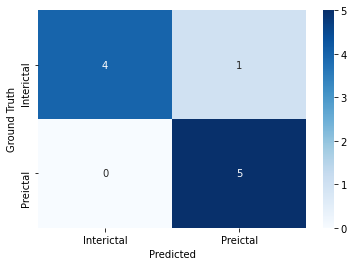

In [37]:
X_train, X_test, y_train, y_test = train_test_split(double_joined, double_joined_targets, test_size=0.1, random_state=42)
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

### Linear SVM

[[4 1]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      0.80      0.89         5
         1.0       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



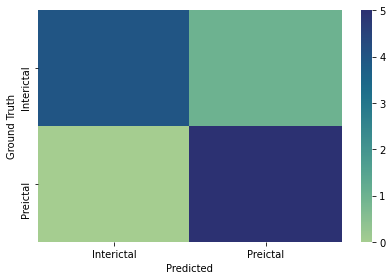

In [43]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
palette = sns.color_palette("crest", as_cmap=True)
ax = sns.heatmap(confuse, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/PIB_SVM_heatmap.pdf')
plt.show()

[[4 1]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      0.80      0.89         5
         1.0       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



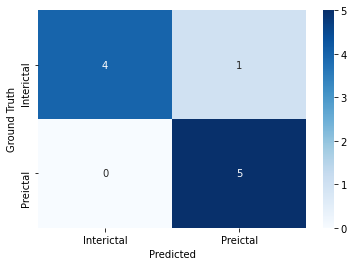

In [39]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()